# Analizando datos del cluster de Univalle

En este *notebook* se mostrarán las instrucciones que permitirán analizar los datos del cluster de Univalle.

El código abajo lee datos el archivo `history.csv`. 

## Cargando datos

In [1]:
import pandas as pd

CSVFILENAME = 'history-2019-10-07.csv.gz'

df = pd.read_csv(CSVFILENAME,compression="gzip",dtype='unicode')

## Definición de índice sobre el *dataframe*

Se usa como índice del análisis el campo `JobCurrentStartDate`.

In [2]:
INDEXFIELD = 'JobCurrentStartDate'

df[INDEXFIELD] = pd.to_datetime(df[INDEXFIELD], unit='s')
df = df.set_index(INDEXFIELD)

## Definición de funciones auxiliares

A continuación se definen unas funciones auxiliares que permitirán visualizar los datos.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math

#
# Esta funcion permite revisar el numero de tareas ejecutadas cada
# mes entre el 'ano1' y el 'ano2', inclusive.
#
def analizarRangoAnos(ano1,ano2, log = True, Users = []):
    values = [] # valores reales
    vallog = [] # valores logaritmicos
    xlabel = []
    contador = 1
    for i in range(ano1, ano2 + 1):
        for j in range(1, 13):
            fecha = '%d-%d'%(i,j)
            if (len(Users) == 0):
                valT = df.loc[fecha].shape[0]
            else:
                dfNoUser = df[df['User'].isin(Users)]
                valT = dfNoUser.loc[fecha].shape[0]
            values.append(valT)
            if valT <= 0:
                valT = 1
            if log:
                vallog.append(math.log2(valT))
            else:
                vallog.append(valT)                
            #xlabel.append(fecha)
            xlabel.append(contador)
            contador = contador + 1

    return (xlabel, vallog, values)

#
# Esta funcion entrega el numero de tareas ejecutadas mes a mes
# de un ano en particular
#
def analizarPorAno(ano, log = True, Users = [] ):
    return analizarRangoAnos(ano, ano, log, Users)

#
# Funcion que grafica dos valores.
#
def showPlot(xlab, val):
    fit = plt.figure()
    plt.plot(xlab,val)
    plt.grid()
    plt.show()

## Numero promedio de tareas por mes

El siguiente fragmento genera una lista de lista que contiene el numero de trabajos por mes por cada año desde el 2015 al 2019.
Luego, se saca un promedio  y lo que se hará es graficar por meses el uso del cluster.

<BarContainer object of 12 artists>

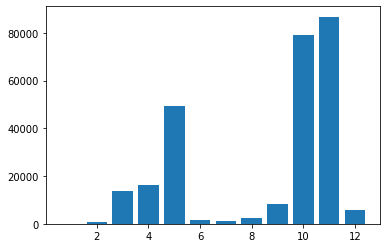

In [4]:
lista = []
for i in range(2015,2020):
    (x,y,values) = analizarPorAno(i,False)
    lista.append(values)
jobsxmes = pd.DataFrame.from_records(lista)
avgjobsxmes = []
for i in range(0,12):
    avgjobsxmes.append(jobsxmes[i].mean())
plt.bar(x, height = avgjobsxmes)

## Numero promedio de tareas por mes por un usuario

El siguiente fragmento genera una lista de lista que contiene el numero de trabajos por mes por cada año desde del 2015 al 2019 por un usuario o varios usuarios en particular.
Luego, se saca un promedio  y lo que se hará es graficar por meses el uso del cluster de ese o esos usuarios.

<BarContainer object of 12 artists>

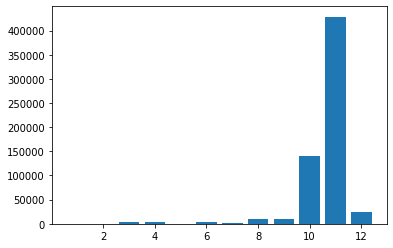

In [7]:
lista = []
#Users = ['rduque@cloud.univalle.edu.co']
Users = []
for i in range(2017,2018):
    (x,y,values) = analizarPorAno(i,False,Users)
    lista.append(values)
jobsxmes = pd.DataFrame.from_records(lista)
avgjobsxmes = []
for i in range(0,12):
    avgjobsxmes.append(jobsxmes[i].mean())
plt.bar(x, height = avgjobsxmes)

Si usted desear revisar el de un año se ejecuta el siguiente código

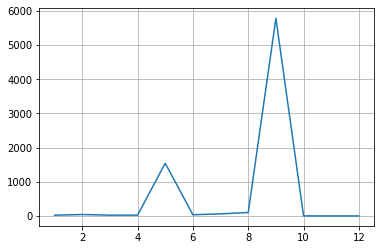

[22, 42, 23, 23, 1540, 35, 61, 101, 5780, 2, 0, 0]

In [8]:
(xlab, vallog, realvalues) = analizarPorAno(2019, False)
showPlot(xlab, vallog)
realvalues

In [17]:
sum(realvalues)

7589

Si usted desea revisar el rango de años del 2015 al 2019 se debe ejecutar el siguiente código.

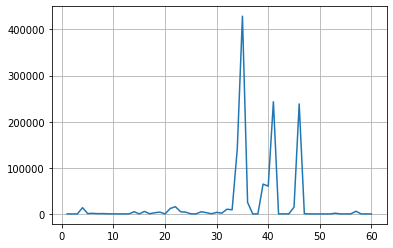

In [9]:
(xlab, vallog, realvalues) = analizarRangoAnos(2015, 2019, False)
showPlot(xlab, vallog)

En la ejecución anterior se inicializó una variable llamada 'realvalues'.
Esta variable contiene las tareas que se ejecutaron por meses.

In [10]:
realvalues

[0,
 0,
 0,
 13588,
 797,
 1211,
 530,
 754,
 204,
 98,
 15,
 36,
 58,
 4732,
 99,
 5433,
 371,
 2590,
 3891,
 5,
 11745,
 15737,
 4793,
 3795,
 186,
 1,
 4711,
 2709,
 299,
 3382,
 1692,
 10217,
 8902,
 141054,
 428541,
 24807,
 9,
 4,
 64624,
 60261,
 243176,
 23,
 25,
 141,
 14711,
 238485,
 526,
 23,
 22,
 42,
 23,
 23,
 1540,
 35,
 61,
 101,
 5780,
 2,
 0,
 0]

Vamos a identificar los usuarios y cuantas tareas han enviado a ejecutar en el cluster.

In [11]:
group = df.groupby('User', as_index = False).count()
# selecciono una columna cualquiera, 'ClusterId'
group = group[['User','ClusterId']]
# 'ClusterId' la renombro como 'Total jobs'
group.columns = ['User', 'Total jobs']
group.sort_values(by='Total jobs')

,User,Total jobs
70,test1@cloud.univalle.edu.co,1
5,c-dorado@cloud.univalle.edu.co,1
17,e-sd-01@cloud.univalle.edu.co,1
27,ma0@cloud.univalle.edu.co,2
18,e-sd-02@cloud.univalle.edu.co,2
...,...,...
20,edza@cloud.univalle.edu.co,21338
31,nmossos@cloud.univalle.edu.co,21495
12,clouduser@cloud.univalle.edu.co,23749
28,ma@cloud.univalle.edu.co,113271


Se identifica cuando **rduque** terminó de ejecutar la última tarea y cuando **rduque** envió la primera tarea.

In [12]:
lastTask = df.loc[df['User'] == 'rduque@cloud.univalle.edu.co'].aggregate({'CompletionDate':'max'})
firstTask = df.loc[df['User'] == 'rduque@cloud.univalle.edu.co'].aggregate({'QDate':'min'})
print("rduque uso el cluster por %d dias"%((int(lastTask) - int(firstTask))/(60*60*24)))

rduque uso el cluster por 923 dias


In [13]:
df.loc[df['User'] == 'rduque@cloud.univalle.edu.co'].aggregate({'CumulativeRemoteUserCpu':'max'})

CumulativeRemoteUserCpu    9990.0
dtype: object